In [1]:
import pandas as pd
from persim import PersImage
%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np

# Loading Persistence Diagrams $H_0$
Remember to filter out **inf** point

In [2]:
pd_non_train = np.load('experiment_data/pd_intervals/not-trained/pd-model_0_ne-0.npz')
pd_train = np.load('experiment_data/pd_intervals/trained/pd-model_0_ne-5.npz')

In [22]:
max(pd_non_train['pd'][0][:-1,1]), max(pd_train['pd'][0][:-1,1])

(0.9664976596832275, 0.9638991355895996)

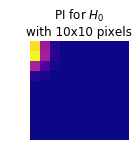

In [17]:
pim = PersImage(spread=0.1, pixels=[10,10], verbose=False)
img = pim.transform(pd_non_train['pd'][0][:-1])
ax = plt.subplot(131)
plt.title("PI for $H_0$\nwith 10x10 pixels")
pim.show(img, ax)

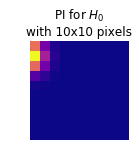

In [18]:
pim = PersImage(spread=0.1, pixels=[10,10], verbose=False)
train_img = pim.transform(pd_train['pd'][0][:-1])
ax = plt.subplot(131)
plt.title("PI for $H_0$\nwith 10x10 pixels")
pim.show(train_img, ax)

(10, 10)

array([[0.        , 0.91172481],
       [0.        , 0.91190767],
       [0.        , 0.91191262],
       ...,
       [0.        , 0.96605211],
       [0.        , 0.96649766],
       [0.        ,        inf]])